In [1]:
import os
os.environ["OPENAI_API_KEY"] = ""

In [2]:
from langchain_core.tools import tool

In [3]:
from langgraph.graph import GraphCommand

### Define tools for specialty agents

- flight-booking agent
- hotel-booking 

In [4]:
from langgraph.prebuilt.chat_agent_executor import make_agent_node, AgentRouterState
from langchain_openai import ChatOpenAI

In [5]:
import uuid

from langgraph.prebuilt import InjectedState
from typing import Annotated, Literal

from langchain_core.runnables import RunnableConfig

In [6]:
model = ChatOpenAI(model="gpt-4o")

In [7]:
def get_state_or_config_key(state: dict, config: RunnableConfig, key: str, raise_if_missing: bool = True):
    user_id = state.get(key) or config.get("configurable", {}).get(key)
    if user_id is None and raise_if_missing:
        raise ValueError(f"{key} is missing")

    return user_id

In [8]:
USERS = [
    {"id": "1", "first_name": "John", "last_name": "Smith", "title": "Mr"},
    {"id": "2", "first_name": "Jane", "last_name": "Doe", "title": "Dr"},
    {"id": "3", "first_name": "Oliver", "last_name": "Smith", "title": "Dr"},
]

# super simplistic
FLIGHTS = [
    {"id": "1", "departure_airport": "BOS", "arrival_airport": "JFK", "airline": "Jet Blue", "date": "2024-11-19"},
    {"id": "2", "departure_airport": "BOS", "arrival_airport": "MIA", "airline": "American Airlines", "date": "2024-11-19"},
    {"id": "3", "departure_airport": "JFK", "arrival_airport": "BOS", "airline": "Jet Blue", "date": "2024-11-29"},
    {"id": "4", "departure_airport": "MIA", "arrival_airport": "BOS", "airline": "American Airlines", "date": "2024-11-29"},
]

# super simplistic (no available dates)
HOTELS = [
    {"id": "1", "location": "New York", "name": "McKittrick Hotel", "neighborhood": "Chelsea"},
    {"id": "2", "location": "New York", "name": "Hyatt", "neighborhood": "Midtown"},
    {"id": "3", "location": "Miami Beach", "name": "Nautilus Hotel", "neighborhood": "South Beach"},
]

# overall itinerary reservations
RESERVATIONS = [
    {
        "number": "1-123",
        "user_id": "1",
        "flight_id": "1",
        "hotel_id": "1",
        "hotel_start_date": "2024-11-19",
        "hotel_end_date": "2024-11-29"
    }
]


def get_reservation(state, config):
    user_id = get_state_or_config_key(state, config, "user_id")
    reservation_number = get_state_or_config_key(state, config, "reservation_number")

    matching_reservations = [
        reservation
        for reservation in RESERVATIONS
        if reservation["user_id"] == user_id and reservation["number"] == reservation_number
    ]

    if len(matching_reservations) == 0:
        return "Couldn't find a reservation for the provided number."

    matching_reservation = matching_reservations[0]
    return matching_reservation


# FLIGHT TOOLS


@tool(response_format="content_and_artifact")
def search_flights(departure_airport: str, arrival_airport: str):
    """Search flights. Use 3-letter airport codes."""
    matching_flights = [
        flight
        for flight in FLIGHTS 
        if flight["departure_airport"] == departure_airport and flight["arrival_airport"] == arrival_airport
    ]
    return matching_flights, GraphCommand(update={"candidate_flights": matching_flights})


@tool(response_format="content_and_artifact")
def book_flight(
    flight_id: str,
    mode: Annotated[Literal["create", "update"], "If you have a reservation number, use 'update' mode"],
    state: Annotated[dict, InjectedState],
    config: RunnableConfig
):
    """Book a flight"""
    user_id = get_state_or_config_key(state, config, "user_id")

    if mode == "create":
        reservation_number = str(uuid.uuid4())
        reservation = {"number": reservation_number, "flight_id": flight_id, "user_id": user_id}
        RESERVATIONS.append(reservation)

        # switch active reservation to the new one
        update = {"reservation_number": reservation_number, "flight_id": flight_id}
    else:
        matching_reservation = get_reservation(state, config)
        matching_reservation["flight_id"] = flight_id
        update = None

    return "Successfully added a reservation for the flight", GraphCommand(update=update)


@tool
def update_flight(
    flight_id: str,
    state: Annotated[dict, InjectedState],
    config: RunnableConfig
):
    """Update flight"""
    matching_reservation = get_reservation(state, config)
    matching_reservation["flight_id"] = flight_id
    return "Successfully updated reservation for the flight"


@tool(response_format="content_and_artifact")
def cancel_flight(
    state: Annotated[dict, InjectedState],
    config: RunnableConfig
):
    """Cancel flight"""
    matching_reservation = get_reservation(state, config)
    del matching_reservation["flight_id"]

    if not matching_reservation.get("hotel_id"):
        # remove reservation completely
        RESERVATIONS.remove(matching_reservation)
        update = {"reservation_number": None}
    else:
        update = {}

    return "Successfully removed flight from the reservation.", GraphCommand(update=update)


# HOTEL TOOLS


@tool(response_format="content_and_artifact")
def search_hotels(location: str):
    """Search hotels. Use offical city names (proper nouns) for locations."""
    matching_hotels = [
        hotel
        for hotel in HOTELS 
        if hotel["location"] == location
    ]
    return matching_hotels, GraphCommand(update={"candidate_hotels": matching_hotels})


@tool(response_format="content_and_artifact")
def book_hotel(
    hotel_id: str,
    mode: Annotated[Literal["create", "update"], "If you have a reservation number, use 'update' mode"],
    state: Annotated[dict, InjectedState],
    config: RunnableConfig
):
    """Book a hotel"""
    user_id = get_state_or_config_key(state, config, "user_id")

    if mode == "create":
        reservation_number = str(uuid.uuid4())
        reservation = {"number": reservation_number, "hotel_id": hotel_id, "user_id": user_id}
        RESERVATIONS.append(reservation)

        # switch active reservation to the new one
        update = {"reservation_number": reservation_number}
    else:
        matching_reservation = get_reservation(state, config)
        matching_reservation["hotel_id"] = hotel_id
        update = None

    return "Successfully added a reservation for the hotel", GraphCommand(update=update)


@tool
def update_hotel_reservation(
    hotel_id: str,
    state: Annotated[dict, InjectedState],
    config: RunnableConfig
):
    """Update hotel reservation"""
    matching_reservation = get_reservation(state, config)
    matching_reservation["hotel_id"] = hotel_id
    return "Successfully updated reservation for the hotel"


@tool(response_format="content_and_artifact")
def cancel_hotel_reservation(
    state: Annotated[dict, InjectedState],
    config: RunnableConfig
):
    """Cancel hotel reservation"""
    matching_reservation = get_reservation(state, config)
    del matching_reservation["hotel_id"]

    if not matching_reservation.get("flight_id"):
        # remove reservation completely
        RESERVATIONS.remove(matching_reservation)
        update = {"reservation_number": None}
    else:
        update = {}

    return "Successfully removed hotel from the reservation.", GraphCommand(update=update)

In [9]:
def make_state_modifier(base_system_prompt: str):
    def state_modifier(state, config):
        system_prompt = base_system_prompt
        full_name = None
    
        # try to pull in the values from the state
        if state.get("user_id"):
            full_name = " ".join([state["user_title"], state["user_first_name"], state["user_last_name"]])
        # fall back on config
        elif config.get("configurable", {}).get("user_id"):
            configurable = config["configurable"]
            full_name = " ".join([configurable["user_title"], configurable["user_first_name"], configurable["user_last_name"]])
    
        if full_name:
            system_prompt += f"\n\nYou already know user's full name: {full_name}"
    
        # Get reservation info
        reservation_number = get_state_or_config_key(state, config, "reservation_number", raise_if_missing=False)
        if reservation_number:
            system_prompt += f"\n\nUser's active reservation number is: {reservation_number}"

        # Get reservation info
        reservation_info = get_state_or_config_key(state, config, "reservation_info", raise_if_missing=False)
        if reservation_info is not None:
            system_prompt += f"\n\nUser's reservations: {reservation_info}"

        # Get flight / hotel info
        candidate_flights = get_state_or_config_key(state, config, "candidate_flights", raise_if_missing=False)
        if candidate_flights:
            system_prompt += f"\n\nLast discussed candidate flights: {candidate_flights}"

        candidate_hotels = get_state_or_config_key(state, config, "candidate_hotels", raise_if_missing=False)
        if candidate_hotels:
            system_prompt += f"\n\nLast discussed candidate hotels: {candidate_hotels}"
    
        return [{"role": "system", "content": system_prompt}] + state["messages"]

    return state_modifier

In [10]:
RESERVATIONS

[{'number': '1-123',
  'user_id': '1',
  'flight_id': '1',
  'hotel_id': '1',
  'hotel_start_date': '2024-11-19',
  'hotel_end_date': '2024-11-29'}]

In [105]:
# for chunk in flight_assistant.stream({"messages": [("user", "i am looking to fly from boston to ny")]}, user_config):
#     print(chunk)
#     print("\n\n")

# for chunk in flight_assistant.stream({"messages": [("user", "yes please")]}, user_config):
#     print(chunk)
#     print("\n\n")

# for chunk in flight_assistant.stream({"messages": [("user", "actually, changed my mind -- can you switch it to bos -> miami?")]}, user_config):
#     print(chunk)
#     print("\n\n")

# for chunk in flight_assistant.stream({"messages": [("user", "yes")]}, user_config):
#     print(chunk)
#     print("\n\n")

# for chunk in flight_assistant.stream({"messages": [("user", "actually, changed my mind -- can you cancel my flight?")]}, user_config):
#     print(chunk)
#     print("\n\n")

In [106]:
# memory = MemorySaver()
# flight_assistant = create_react_agent(
#     model,
#     [search_flights, book_flight, update_flight, cancel_flight],
#     state_schema=State,
#     state_modifier=make_state_modifier("You are a flight booking assistant."),
#     checkpointer=memory
# )

# hotel_assistant = create_react_agent(
#     model,
#     [search_hotels, book_hotel, update_hotel_reservation, cancel_hotel_reservation],
#     state_schema=State,
#     state_modifier=make_state_modifier("You are a hotel booking assistant"),
#     checkpointer=memory
# )

In [107]:
# for chunk in hotel_assistant.stream({"messages": [("user", "i am looking for a hotel in ny")], "reservation_number": "1-123"}, user_config):
#     print(chunk)
#     print("\n\n")

# for chunk in hotel_assistant.stream({"messages": [("user", "book mckittrick please")]}, user_config):
#     print(chunk)
#     print("\n\n")

# for chunk in hotel_assistant.stream({"messages": [("user", "actually, nvm, cancel it")]}, user_config):
#     print(chunk)
#     print("\n\n")

### Main agent tools

In [11]:
from langgraph.prebuilt.handoff import handoff

In [34]:
transfer_to_hotel_assistant = handoff(
    goto="hotel_assistant",
    tool_message="Transferred to hotel assistant",
    name="transfer_to_hotel_assistant",
    description="Transfer user to the hotel-booking assistant that can create/update or cancel bookings."
)
transfer_to_flight_assistant = handoff(
    goto="flight_assistant",
    tool_message="Transferred to hotel assistant",
    name="transfer_to_flight_assistant",
    description="Transfer user to the flight-booking assistant that can create/update or cancel bookings."
)
transfer_to_main_assistant = handoff(
    goto="main_assistant",
    tool_message="Transferred to main booking assistant",
    name="transfer_to_main_assistant",
    description="Transfer user to the main travel booking assistant if you don't know how to help the user."
)

In [35]:
from typing import Optional

class State(AgentRouterState):
    # user info
    user_id: str
    user_title: str
    user_first_name: str
    user_last_name: str
    # current reservation number
    reservation_number: str
    # current reservation INFO
    reservation_info: list[dict]
    # current flights/hotels under consideration
    candidate_flights: list[str]
    candidate_hotels: list[str]

In [36]:
def expand_reservation(reservation):
    expanded_reservation = {**reservation}

    if flight_id := reservation.get("flight_id"):
        flight = [flight for flight in FLIGHTS if flight_id == flight_id][0]
        flight_info = {**flight}
        flight_info.pop("id")
        expanded_reservation["flight_info"] = flight_info

    if hotel_id := reservation.get("hotel_id"):
        hotel = [hotel for hotel in HOTELS if hotel_id == hotel_id][0]
        hotel_info = {**hotel}
        hotel_info.pop("id")
        expanded_reservation["hotel_info"] = hotel_info

    if flight_id is None and hotel_id is None:
        raise ValueError("Malformed reservation -- missing flight ID and hotel ID")

    return expanded_reservation


@tool(response_format="content_and_artifact")
def get_reservations(state: Annotated[dict, InjectedState], config: RunnableConfig):
    """Get reservations for the user."""
    user_id = get_state_or_config_key(state, config, "user_id")
    reservations = [
        expand_reservation(reservation)
        for reservation in RESERVATIONS
        if reservation["user_id"] == user_id
    ]
    return reservations, GraphCommand(update={"reservation_info": reservations})

In [37]:
@tool(response_format="content_and_artifact")
def verify_user_information(last_name: str, reservation_number: Optional[str]):
    """Look up and verify user information once they provide last name and, optionally, reservation number.

    Args:
        last_name: User last name.
        reservation_number: Ask for this if the user is trying to modify an existing reservation.
    """
    # the lookups are dumb
    matching_users = [user for user in USERS if user["last_name"].lower() == last_name.lower()]
    if len(matching_users) == 0:
        return "No users found", GraphCommand(goto="main_assistant")
    elif len(matching_users) > 1 and not reservation_number:
        return "Found multiple users with this last name. Please provider reservation number.", None
    
    if reservation_number:
        matching_reservations = [
            reservation 
            for reservation in RESERVATIONS 
            if reservation["number"] == reservation_number
        ]
        if len(matching_reservations) > 1:
            raise ValueError("Found multiple reservations for the same number")

        if len(matching_reservations) == 1:
            reservation = matching_reservations[0]
            update = {"reservation_number": reservation["number"]}
            matching_users = [user for user in matching_users if user["id"] == reservation["user_id"]]
        else:
            return "Couldn't find a reservation for the provided number.", None

    user = matching_users[0]
    update = {
        "user_id": user["id"],
        "user_last_name": user["last_name"],
        "user_first_name": user["first_name"],
        "user_title": user["title"],
    }

    if reservation_number:
        update["reservation_number"] = reservation_number
        update["reservation_info"] = [expand_reservation(r) for r in matching_reservations]
    else:
        update["reservation_info"] = [
            expand_reservation(reservation)
            for reservation in RESERVATIONS 
            if reservation["user_id"] == user_id
        ]

    return "Successfully authenticated", GraphCommand(update=update)

### What's a good way to handle the user info via the config?

* the question is where the user info in this example should ultimately live -- in the state or in the config?
    * if we want it to be in the state, we'd need to populate it with the values from the config in a separate step
    * if we only need this for state modifier to include in the prompt, we can just pull in the values from the config directly
* can also have a dedicated node in the beginning that updates the state to include information from the config
 
For this example, will try to look in the state, and then fall back on the config

In [38]:
from langgraph.prebuilt import create_react_agent

In [39]:
from langgraph.graph import StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

In [40]:
from functools import partial
from langchain_core.messages import HumanMessage

# output processors

def make_output_processor(agent_name: str = None):
    def keep_last_message_as_human(state):
        updated_state = state.copy()
        last_message_content = updated_state["messages"][-1].content
        last_message = HumanMessage(content=last_message_content, name=agent_name)
        updated_state["messages"] = [last_message]
        return updated_state
    return keep_last_message_as_human

In [41]:
MAIN_ASSISTANT_SYSTEM_PROMPT = (
    "You are a travel booking assistant who can help the user with booking travel (flights and hotel) and updating existing bookings. "
    "If you don't know their last name, you MUST ask them for it AND THEN call verification tool. "
    "You MUST verify user info but ONLY if you don't already know their name. "
    "Before transferring to flight/hotel assistants, check if the user has any existing reservations."
)

In [43]:
main_assistant = make_agent_node(
    model,
    [verify_user_information, transfer_to_flight_assistant, transfer_to_hotel_assistant],
    state_schema=State,
    state_modifier=make_state_modifier(MAIN_ASSISTANT_SYSTEM_PROMPT)
)

flight_assistant = make_agent_node(
    model,
    [search_flights, book_flight, update_flight, cancel_flight, transfer_to_hotel_assistant, transfer_to_main_assistant],
    state_schema=State,
    state_modifier=make_state_modifier("You are a flight booking assistant"),
    output_processor=make_output_processor(agent_name="flight_assistant"),
)

hotel_assistant = make_agent_node(
    model,
    [search_hotels, book_hotel, update_hotel_reservation, cancel_hotel_reservation, transfer_to_flight_assistant, transfer_to_main_assistant],
    state_schema=State,
    state_modifier=make_state_modifier("You are a hotel booking assistant"),
    output_processor=make_output_processor(agent_name="hotel_assistant"),
)

### Define the graph

In [44]:
from langgraph.prebuilt.chat_agent_executor import add_entrypoint_router

In [45]:
from langgraph.errors import NodeInterrupt

In [46]:
def entry_router(state: State) -> Literal["resolve_user_info", "main_assistant", "flight_assistant", "hotel_assistant"]:
    if state.get("user_id") is not None:
        return state.get("node", "main_assistant")
    else:
        return "resolve_user_info"

In [47]:
def resolve_user_info(state: State, config: RunnableConfig):
    user_id = get_state_or_config_key(state, config, "user_id", raise_if_missing=False)
    user_last_name = get_state_or_config_key(state, config, "user_last_name", raise_if_missing=False)
    reservation_number = get_state_or_config_key(state, config, "reservation_number", raise_if_missing=False)
    
    if user_id is not None:
        matching_users = [user for user in USERS if user["id"] == user_id]
    elif user_last_name is not None:
        matching_users = [user for user in USERS if user["last_name"].lower() == user_last_name.lower()]

    if len(matching_users) == 0:
        raise NodeInterrupt("No matching users found")

    elif len(matching_users) > 1 and not reservation_number:
        raise NodeInterrupt("Found multiple users with this last name. Please provider reservation number.")

    if reservation_number:
        matching_reservations = [
            reservation 
            for reservation in RESERVATIONS
            if reservation["number"] == reservation_number
        ]
        if len(matching_reservations) > 1:
            raise ValueError("Found multiple reservations for the same number")

        if len(matching_reservations) == 1:
            reservation = matching_reservations[0]
            update = {"reservation_number": reservation["number"]}
            matching_users = [user for user in matching_users if user["id"] == reservation["user_id"]]
        else:
            raise NodeInterrupt("Couldn't find a reservation for the provided number.")

    user = matching_users[0]
    update = {
        "user_id": user["id"],
        "user_last_name": user["last_name"],
        "user_first_name": user["first_name"],
        "user_title": user["title"],
    }

    if reservation_number:
        update["reservation_number"] = reservation_number
        update["reservation_info"] = [expand_reservation(r) for r in matching_reservations]
    else:
        update["reservation_info"] = [
            expand_reservation(reservation)
            for reservation in RESERVATIONS 
            if reservation["user_id"] == user_id
        ]

    return update

In [48]:
customer_support_builder = StateGraph(State)

# a node that processes provided config and populates the state
customer_support_builder.add_node("resolve_user_info", resolve_user_info)
customer_support_builder.add_node("main_assistant", main_assistant)
customer_support_builder.add_node("flight_assistant", flight_assistant)
customer_support_builder.add_node("hotel_assistant", hotel_assistant)

customer_support_builder.add_conditional_edges(START, entry_router)
customer_support_builder.add_edge("resolve_user_info", "main_assistant")

checkpointer = MemorySaver()
customer_support_graph = customer_support_builder.compile(checkpointer=checkpointer)

In [49]:
from IPython.display import display, Image

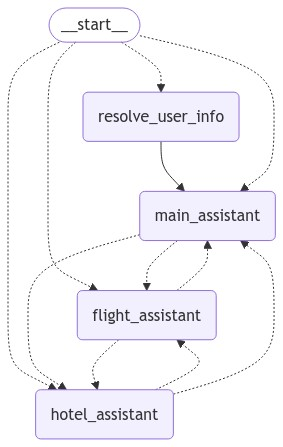

In [50]:
display(Image(customer_support_graph.get_graph().draw_mermaid_png()))

In [51]:
user_info = {f"user_{k}": v for k, v in USERS[0].items()}

In [52]:
# config = {"configurable": {"thread_id": "1"}}
config = {"configurable": {"thread_id": "1", "reservation_number": "1-123", **user_info}}

In [53]:
for chunk in customer_support_graph.stream({"messages": [("user", "hi, i'd like to book a flight")]}, config, subgraphs=True):
    print(chunk)
    print("\n\n")

((), {'resolve_user_info': {'user_id': '1', 'user_title': 'Mr', 'user_first_name': 'John', 'user_last_name': 'Smith', 'reservation_number': '1-123', 'reservation_info': [{'number': '1-123', 'user_id': '1', 'flight_id': '1', 'hotel_id': '1', 'hotel_start_date': '2024-11-19', 'hotel_end_date': '2024-11-29', 'flight_info': {'departure_airport': 'BOS', 'arrival_airport': 'JFK', 'airline': 'Jet Blue', 'date': '2024-11-19'}, 'hotel_info': {'location': 'New York', 'name': 'McKittrick Hotel', 'neighborhood': 'Chelsea'}}]}})



(('main_assistant:559a09bb-0843-2a42-9a0a-56e79971baa2',), {'agent': {'messages': [AIMessage(content='Hi Mr. Smith, before I transfer you to the flight-booking assistant, I noticed you have an existing reservation with the number 1-123. Would you like to update this reservation, or are you looking to make a new booking?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 383, 'total_tokens': 433, 'completion

In [ ]:
# # for chunk in customer_support_graph.stream({"messages": [("user", "hi, i'd like to book a flight")]}, config, subgraphs=True):
# #     print(chunk)
# #     print("\n\n")

# # for chunk in customer_support_graph.stream({"messages": [("user", "my last name is smith")]}, config, subgraphs=True):
# #     print(chunk)
# #     print("\n\n")

# # for chunk in customer_support_graph.stream({"messages": [("user", "sure, it's 1-123")]}, config, subgraphs=True):
# #     print(chunk)
# #     print("\n\n")

# for chunk in customer_support_graph.stream({"messages": [("user", "i am looking to fly from boston to ny (jfk)")]}, config, subgraphs=True):
#     print(chunk)
#     print("\n\n")

# # for chunk in customer_support_graph.stream({"messages": [("user", "ah great keep it then! i'd also love to book a hotel")]}, config, subgraphs=True):
# #     print(chunk)
# #     print("\n\n")

# for chunk in customer_support_graph.stream({"messages": [("user", "actually, i'd like to change my flight. want to fly to miami instead")]}, config, subgraphs=True):
#     print(chunk)
#     print("\n\n")